# Data Exploration and Feature Grouping

In this notebook we do some quick cleaning of the dataset and perform LDA with features grouped according to correlation.  

In [1]:
# import libraries needed

import pandas as pd
import numpy as np
from pennylane import numpy as np
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane_qiskit import IBMQDevice
from pennylane_qiskit import BasicAerDevice
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# visualization

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time
start = time.time()

## Clean-up and Quick Run

In [2]:
# Read out CSV and sets/samples creation

df = pd.read_csv('dataset_cleaned.csv', sep=',')
df = df.astype(float)
df = df.drop(['Unnamed: 0'], axis = 1)
df.describe()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_13,col_14,col_15,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
count,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,...,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000,20468.000000
mean,3.226256,294.793043,0.420021,2.329343,0.083594,0.939857,2.386066,0.038646,0.363152,0.330760,...,0.004935,0.358120,0.002443,0.308384,0.190737,0.000049,0.049345,0.024282,43.486125,0.265683
std,20.564308,717.541984,7.367275,10.068512,0.840537,4.222896,3.018140,0.192754,0.480920,0.470498,...,0.073478,0.479459,0.049366,0.461837,0.392892,0.006990,0.216593,0.305079,59.217560,0.441707
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000
50%,0.000000,97.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000
75%,2.000000,283.000000,0.000000,2.000000,0.000000,1.000000,6.000000,0.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,61.250000,1.000000
max,2301.000000,37808.000000,904.000000,772.000000,54.000000,230.000000,11.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,747.000000,1.000000


## Feature Grouping

We want to split the features into groups that are similar within but distinct between groups. Let's take a look at the correlation matrix.

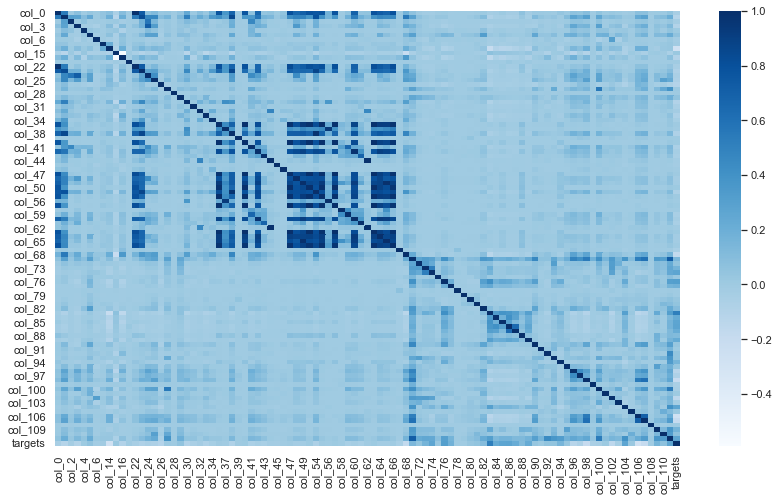

In [3]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df.corr()
heatmap = sns.heatmap(corr, annot=False, cmap="Blues", fmt='.1g')

Some columns show a much stronger correlation than others. Let's see if we could group the more strongly correlated ones together. This is probably not optimized but it is a test of idea.

In [4]:
ordered = df[corr['col_0'].sort_values(ascending=False).index].drop('targets', axis = 1)
ordered.head()

,col_0,col_22,col_47,col_66,col_63,col_57,col_50,col_36,col_55,col_40,...,col_77,col_104,col_74,col_73,col_84,col_87,col_89,col_86,col_83,col_15
0,9.0,9.0,36.0,32.0,32.0,11.0,15.0,97.0,56.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,13.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,17.0,23.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,21.0,34.0,20.0,36.0,36.0,52.0,39.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


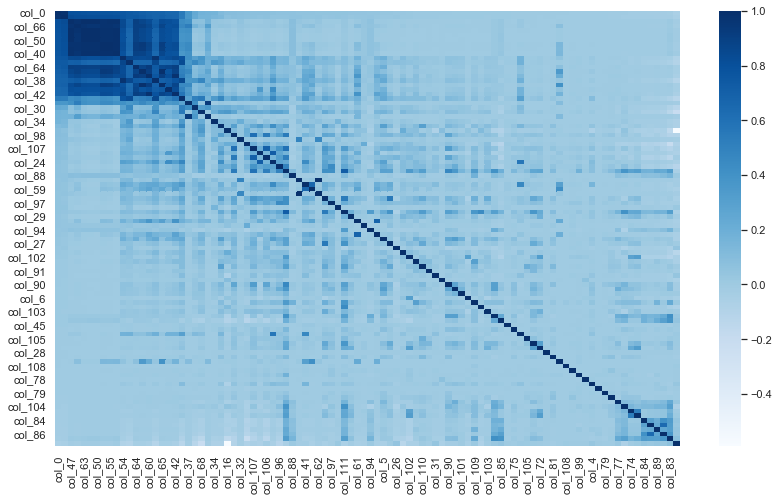

In [5]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr_ordered = ordered.corr()
heatmap = sns.heatmap(corr_ordered, annot=False, cmap="Blues", fmt='.1g')

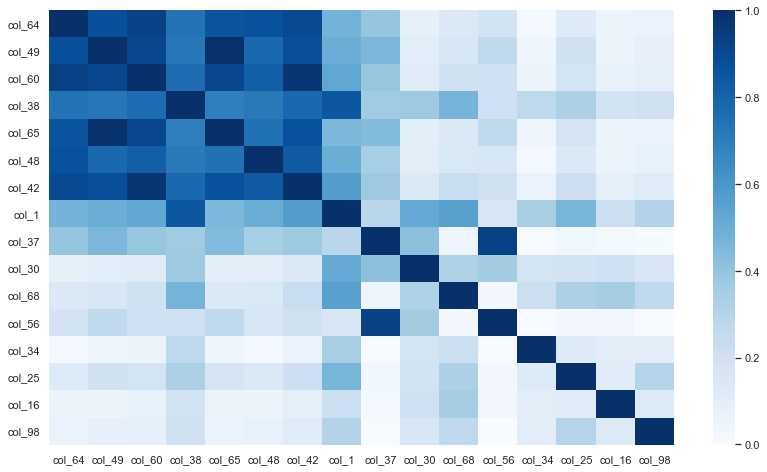

In [111]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr2 = ordered.loc[:,'col_64':'col_98'].corr()
heatmap = sns.heatmap(corr2, annot=False, cmap="Blues", fmt='.1g')

We will pick `col_37`/`col_30` as our first splitting point for the two groups. This results in an uneven split (21,75). We perform the LDA and QML on the same sample.

In [112]:
first_group = ordered.loc[:, :'col_37']
Left_over = ordered.loc[:, 'col_30':]

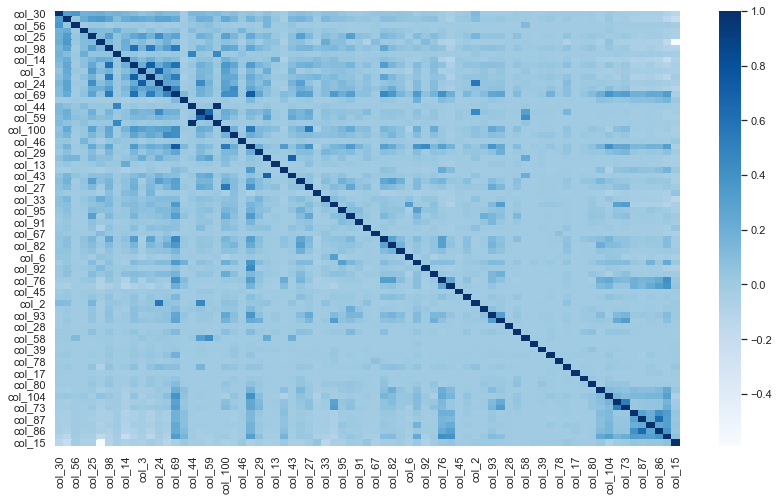

In [113]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr_left = Left_over.corr()
heatmap = sns.heatmap(corr_left, annot=False, cmap="Blues", fmt='.1g')

In [114]:
ordered_left = Left_over[corr_left['col_69'].sort_values(ascending=False).index]

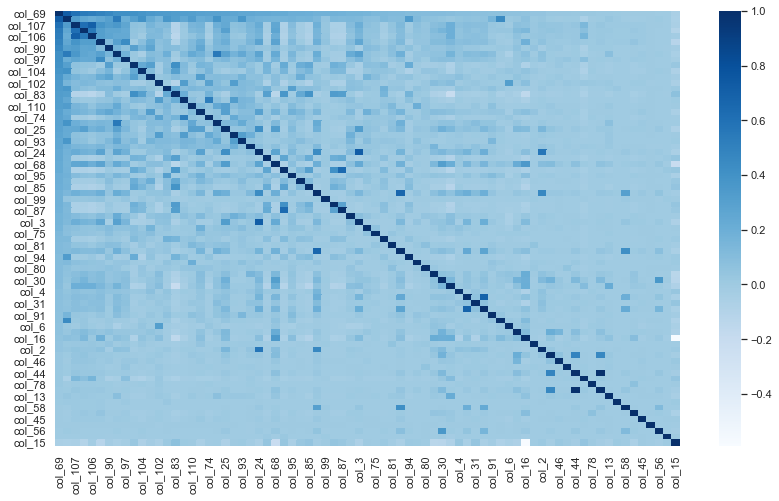

In [115]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr_left_o = ordered_left.corr()
heatmap = sns.heatmap(corr_left_o, annot=False, cmap="Blues", fmt='.1g')

Less obvious for these, well simply split the ordered in half.

In [116]:
group1 = ordered.loc[:, :'col_37'].columns
group2 = ordered_left.iloc[:, :ordered_left.shape[1]//2].columns
group3 = ordered_left.iloc[:, ordered_left.shape[1]//2:].columns

In [117]:
ordred_sample = df_clean.sample(2000)
train,test = train_test_split(ordred_sample, test_size=0.30, random_state=10)
train_set = train
test_set = test
np.random.seed(42)

In [118]:
ordred_sample.head(10)

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_13,col_14,col_15,...,col_103,col_104,col_105,col_106,col_107,col_108,col_109,col_110,col_111,targets
10074,6.0,146.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,37.0,0.0
11366,0.0,125.0,0.0,2.0,0.0,0.0,6.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,0.0
15121,0.0,163.0,0.0,1.0,0.0,3.0,2.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,78.0,0.0
12527,4.0,390.0,0.0,2.0,0.0,4.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,21.0,0.0
9992,1.0,271.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
3432,0.0,177.0,0.0,0.0,0.0,11.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,58.0,1.0
10958,5.0,873.0,0.0,5.0,0.0,0.0,7.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0
8639,5.0,302.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13965,0.0,9.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5026,0.0,54.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [119]:
# Separation of labels

y_train = train_set[['targets']]
x_train = train_set.drop('targets', axis=1)


y_test = test_set[['targets']]
x_test = test_set.drop('targets', axis=1)

In [120]:
# grouping features

features_a = x_train[group1]
features_b = x_train[group2]
features_c = x_train[group3]

features_a_test = x_test[group1]
features_b_test = x_test[group2]
features_c_test = x_test[group3]
features_a.shape, features_b.shape,features_c.shape

((1400, 21), (1400, 37), (1400, 38))

In [121]:
features_a.columns

Index(['col_0', 'col_22', 'col_47', 'col_66', 'col_63', 'col_57', 'col_50',
       'col_36', 'col_55', 'col_40', 'col_54', 'col_23', 'col_64', 'col_49',
       'col_60', 'col_38', 'col_65', 'col_48', 'col_42', 'col_1', 'col_37'],
      dtype='object')

### LDA Features

In [122]:
# transform the features

lda = LDA(n_components=1)
features_lda_1 = lda.fit_transform(features_a, y_train.values.ravel())
features_lda_1_test = lda.transform(features_a_test)

features_lda_2 = lda.fit_transform(features_b, y_train.values.ravel())
features_lda_2_test = lda.transform(features_b_test)

features_lda_3 = lda.fit_transform(features_c, y_train.values.ravel())
features_lda_3_test = lda.transform(features_c_test)

In [123]:
features_lda_1 = pd.DataFrame(features_lda_1)
features_lda_2 = pd.DataFrame(features_lda_2)
features_lda_3 = pd.DataFrame(features_lda_3)

features_lda_1_test = pd.DataFrame(features_lda_1_test)
features_lda_2_test = pd.DataFrame(features_lda_2_test)
features_lda_3_test = pd.DataFrame(features_lda_3_test)

In [124]:
features_lda_1.head(), features_lda_2.head(),features_lda_3.head()

(           0
 0   0.401935
 1  10.605835
 2  -1.048846
 3   0.418574
 4   0.069082,
           0
 0 -0.569282
 1 -1.484085
 2 -1.254430
 3 -0.791507
 4 -1.349090,
           0
 0 -1.051580
 1  3.429497
 2 -1.255544
 3  0.420660
 4 -1.392853)

In [125]:
# combine the 2 features

x_train_lda = pd.concat([features_lda_1,features_lda_2,features_lda_3], axis = 1)
x_train_lda.columns = ["feature1", "feature2", "feature3"]
x_test_lda = pd.concat([features_lda_1_test,features_lda_2_test,features_lda_3_test], axis = 1)
x_test_lda.columns = ["feature1", "feature2", "feature3"]

In [126]:
x_train_lda

,feature1,feature2,feature3
0,0.401935,-0.569282,-1.051580
1,10.605835,-1.484085,3.429497
2,-1.048846,-1.254430,-1.255544
3,0.418574,-0.791507,0.420660
4,0.069082,-1.349090,-1.392853
...,...,...,...
1395,0.317657,-0.216462,0.460720
1396,0.356630,0.873146,2.704771
1397,0.053135,0.277998,-1.137192
1398,0.170560,-1.248066,0.690121


In [127]:
x_test_lda

,feature1,feature2,feature3
0,-1.303358,-1.156117,-0.768065
1,0.381894,-0.262228,0.485719
2,0.380457,0.729934,3.630054
3,0.476069,-0.650674,0.309824
4,0.123563,-0.931123,0.205417
...,...,...,...
595,-2.107703,-0.542479,-0.164825
596,-0.735956,-0.421222,-1.722645
597,0.337215,-0.523927,0.393819
598,0.656739,-3.772050,0.354136


In [128]:
# Normalize

std_scale = StandardScaler().fit(x_train_lda)
data = std_scale.transform(x_train_lda)

std_scale = StandardScaler().fit(x_test_lda)
x_test_lda_n = std_scale.transform(x_test_lda)

In [129]:
x_test_lda_n

array([[-1.05687867, -0.91322353, -0.29833986],
       [ 0.30861562, -0.27105695,  0.2037446 ],
       [ 0.3074508 ,  0.44170903,  1.46291118],
       ...,
       [ 0.27241381, -0.45906056,  0.1669431 ],
       [ 0.53131213, -2.79250071,  0.15105149],
       [-0.2414701 , -0.82255264, -0.60246607]])

In [130]:
n_dim = 3

In [131]:
# Review the balance of the target variable in train

y_train.value_counts(normalize=True)*100

targets
0.0        73.714286
1.0        26.285714
dtype: float64

In [132]:
# Review the balance of the target variable in test

y_test.value_counts(normalize=True)*100

targets
0.0        71.333333
1.0        28.666667
dtype: float64

### QML

We then perform quantum machine learning using the two LDA features.

In [133]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits, shots=1024)
#dev = qml.device('default.qubit.tf', wires = num_qubits, shots=1024)
#dev = qml.device('qiskit.ibmq', wires = num_qubits, backend='ibmq_manila', ibmqx_token="6cc75c58fc80fea56cb8dd391f8fbcfdb676a3dc7005493728bc9da7ea753e31a2110a01e3a0cc83f1a98f5ca79e32956fc66c11b5eea4cae163b3fa996be356", shots=256)
#dev = qml.device('qiskit.basicaer', wires = num_qubits, shots = 256)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [134]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print(weights_init, bias_init)

[[[ 0.00496714 -0.00138264  0.00647689]
  [ 0.0152303  -0.00234153 -0.00234137]
  [ 0.01579213  0.00767435 -0.00469474]]

 [[ 0.0054256  -0.00463418 -0.0046573 ]
  [ 0.00241962 -0.0191328  -0.01724918]
  [-0.00562288 -0.01012831  0.00314247]]

 [[-0.00908024 -0.01412304  0.01465649]
  [-0.00225776  0.00067528 -0.01424748]
  [-0.00544383  0.00110923 -0.01150994]]

 [[ 0.00375698 -0.00600639 -0.00291694]
  [-0.00601707  0.01852278 -0.00013497]
  [-0.01057711  0.00822545 -0.01220844]]

 [[ 0.00208864 -0.0195967  -0.01328186]
  [ 0.00196861  0.00738467  0.00171368]
  [-0.00115648 -0.00301104 -0.01478522]]] 0.0


In [135]:
circuit(weights_init, data[0])

tensor(-0.11132812, requires_grad=True)

In [136]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [137]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [138]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [139]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [140]:
Y = np.array(y_train.values[:,0] * 2 - np.ones(len(y_train.values[:,0])), requires_grad = False)  # shift label from {0, 1} to {-1, 1}
X = np.array(data, requires_grad=False)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(0.39601828, requires_grad=False), tensor(-0.43432824, requires_grad=False), tensor(-0.96778402, requires_grad=False)], Y = -1
X = [tensor(10.44971129, requires_grad=False), tensor(-1.13226888, requires_grad=False), tensor(3.1562148, requires_grad=False)], Y =  1
X = [tensor(-1.03340618, requires_grad=False), tensor(-0.95705552, requires_grad=False), tensor(-1.15549491, requires_grad=False)], Y = -1
X = [tensor(0.41241242, requires_grad=False), tensor(-0.60387295, requires_grad=False), tensor(0.38713954, requires_grad=False)], Y = -1
X = [tensor(0.06806546, requires_grad=False), tensor(-1.02927561, requires_grad=False), tensor(-1.2818625, requires_grad=False)], Y = -1


In [141]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [142]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(50):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

New best
Iter:     1 | Cost: 0.8321581 | Accuracy: 0.7392857 
New best
Iter:     2 | Cost: 0.7032348 | Accuracy: 0.7700000 
New best
Iter:     3 | Cost: 0.6458986 | Accuracy: 0.7857143 
New best
Iter:     4 | Cost: 0.6408274 | Accuracy: 0.7900000 
New best
Iter:     5 | Cost: 0.6352138 | Accuracy: 0.7964286 
Iter:     6 | Cost: 0.6395144 | Accuracy: 0.7950000 
New best
Iter:     7 | Cost: 0.6218306 | Accuracy: 0.8014286 
New best
Iter:     8 | Cost: 0.6089275 | Accuracy: 0.8071429 
New best
Iter:     9 | Cost: 0.5994851 | Accuracy: 0.8078571 
Iter:    10 | Cost: 0.6291717 | Accuracy: 0.8050000 
Iter:    11 | Cost: 0.6285832 | Accuracy: 0.7914286 
Iter:    12 | Cost: 0.6118298 | Accuracy: 0.7685714 
Iter:    13 | Cost: 0.6146949 | Accuracy: 0.7414286 
Iter:    14 | Cost: 0.6155200 | Accuracy: 0.7507143 
Iter:    15 | Cost: 0.6112061 | Accuracy: 0.7785714 
Iter:    16 | Cost: 0.6052122 | Accuracy: 0.7907143 
Iter:    17 | Cost: 0.5948368 | Accuracy: 0.8064286 
New best
Iter:    18 | Cost

In [143]:
Yte = np.array(y_test.values[:,0] * 2 - np.ones(len(y_test.values[:,0])), requires_grad = False)
Xte = np.array(normalize(x_test_lda_n), requires_grad=False)

In [144]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.5195109293724983, Accuracy: 86.0%


In [145]:
pd.DataFrame((predictions, Yte), ('Predictions', 'Test')).T

,Predictions,Test
0,-1.0,-1.0
1,-1.0,-1.0
2,1.0,1.0
3,-1.0,-1.0
4,-1.0,-1.0
...,...,...
595,-1.0,-1.0
596,-1.0,-1.0
597,-1.0,-1.0
598,-1.0,1.0


In [146]:
# Print the classification report and important metrics

print(metrics.classification_report(predictions,Yte))
print(f"precisioin score: {metrics.precision_score(predictions,Yte)}")
print(f"recall score: {metrics.recall_score(predictions,Yte)}")
print(f"f1 score: {metrics.f1_score(predictions,Yte)}")
print(f"balanced accuracy: {metrics.balanced_accuracy_score(predictions,Yte)}")
print(f"confusion matrix: {metrics.confusion_matrix(predictions,Yte)}")

              precision    recall  f1-score   support

        -1.0       0.97      0.85      0.91       493
         1.0       0.56      0.90      0.69       107

    accuracy                           0.85       600
   macro avg       0.77      0.87      0.80       600
weighted avg       0.90      0.85      0.87       600

precisioin score: 0.5581395348837209
recall score: 0.897196261682243
f1 score: 0.6881720430107527
balanced accuracy: 0.8715190233360505
confusion matrix: [[417  76]
 [ 11  96]]
